In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min

import torch.utils.data
import os
import random

from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GNNExplainer
from torch_geometric.nn import global_mean_pool, GlobalAttention

In [2]:
# Learned from: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharingand 
    
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        
        num_hidden_units = 64 
        self.conv0 = GCNConv(num_node_features, num_hidden_units)
        self.conv1 = GCNConv(num_hidden_units, num_hidden_units)
        self.conv2 = GCNConv(num_hidden_units, num_hidden_units)
        self.conv3 = GCNConv(num_hidden_units, num_hidden_units)
        
        self.pool0 = GlobalAttention(Linear(num_hidden_units, 1))
        self.pool1 = GlobalAttention(Linear(num_hidden_units, 1))
        self.pool2 = GlobalAttention(Linear(num_hidden_units, 1))
        self.pool3 = GlobalAttention(Linear(num_hidden_units, 1))
        
        self.lin = Linear(num_hidden_units, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv0(x, edge_index)
        x = x.relu()
        
        _ = self.pool0(x, batch) 
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        
        _ = self.pool1(x, batch)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        
        _ = self.pool2(x, batch)
        
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = self.pool3(x, batch)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x
    
global activation_list
activation_list = {}

def get_activation(idx):
    '''Learned from: https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6'''
    def hook(model, input, output):
        activation_list[idx] = output.detach()

    return hook

def register_hooks(model):
    # register hooks to extract activations
    model.pool0.register_forward_hook(get_activation('pool0'))
    model.pool1.register_forward_hook(get_activation('pool1'))
    model.pool2.register_forward_hook(get_activation('pool2'))
    model.pool3.register_forward_hook(get_activation('pool3'))
    
    return model

In [3]:
def test(model, dataloader):
    # enter evaluation mode
    model.eval()

    correct = 0
    for data in dataloader:
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    
    return correct / len(dataloader.dataset)

def train(model, train_loader, test_loader, plot=False, save=False):
    # register hooks to track activation
    model.train()
    model = register_hooks(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    # list of accuracies
    train_accuracies, test_accuracies = list(), list()
    
    for epoch in range(10):
        test_loader_iter = iter(test_loader)
        
        for data in train_loader:        
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            
            # calculate loss
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

        # get accuracy
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)

        ## add to list and print
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc), end = "\r")


    # plut accuracy graph
    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()
        
    if save:
        torch.save(model.state_dict(), "models/mutagenicity_model.pkl")
        
        with open("models/mutagenicity_activation.txt", 'wb') as file:
            pickle.dump(activation_list, file)

In [4]:
def load_data():    
#     graphs = read_graphfile("../../data", "mutagenicity")

    graphs = TUDataset(root='../../data/TUDataset', name='Mutagenicity')
    
    return graphs

def preprocess_input_graphs(graphs):
    torch.manual_seed(0)
    graphs = graphs.shuffle()
    
    train_idx = int(len(graphs) * 0.8)
    train_set = graphs[:train_idx]
    test_set = graphs[train_idx:]
    
    print(type(graphs))
    
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
    full_loader = DataLoader(graphs, batch_size=len(graphs), shuffle=False)
    
    return train_loader, test_loader, full_loader


def preprocess2(graphs):
    train_size = 0.80
    train_mask = np.random.rand(len(graphs)) < train_size
    test_mask = ~train_mask
    
    full_loader = DataLoader(graphs, batch_size=len(graphs), shuffle=False)
    data = next(iter(full_loader))
    
    return full_loader, train_mask, test_mask

Extracting ../../data/TUDataset/Mutagenicity/Mutagenicity.zip
Processing...
Done!
<class 'torch_geometric.datasets.tu_dataset.TUDataset'>


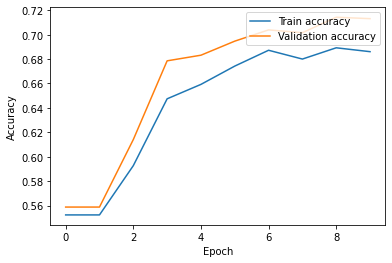

In [5]:
graphs = load_data()
train_loader, test_loader, full_loader = preprocess_input_graphs(graphs)
# full_loader, train_mask, test_mask = preprocess2(graphs)

num_node_features = graphs.num_node_features
num_classes = graphs.num_classes
model = GCN(num_node_features, num_classes)

load_pretrained = False

if load_pretrained:
    model.load_state_dict(torch.load("models/mutagenicity_model.pkl"))
    model.eval()

    with open("models/mutagenicity_activation.txt", 'rb') as file:
        activation_list = pickle.loads(file.read())

else:
    train(model, train_loader, test_loader, plot=True, save=True)

Explain node 0: 100%|██████████| 200/200 [00:00<00:00, 324.93it/s]


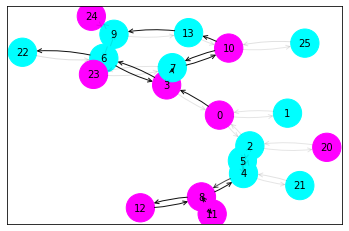

In [7]:
# geometric
data = next(iter(full_loader))
x, edge_index = data.x, data.edge_index

explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
node_idx = 0
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index, batch=data.batch)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

In [ ]:
# ### Analysis
# for data in full_loader:        
#     print(data.batch)
#     out = model(data.x, data.edge_index, data.batch)

# num_layers = len(activation_list)
# labels = next(iter(full_loader)).y

# def plot_raw_activation_space(data, labels):
#     fig, axs = plt.subplots(num_layers, 1, figsize=(30, 30))
#     fig.suptitle('Raw Activation Space (coloured by labels)', fontsize=40)

#     counter = 0
#     for ax in axs:
#         item = data[f'pool{counter}']
#         print(item.shape)
#         ax.set_title("Activations of Layer {}".format(counter), fontsize=20)
#         scatter = ax.scatter(item[:,0], item[:,1], c=labels, cmap='rainbow')
#         ax.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(labels)), fontsize=15)
#         counter += 1
            

# # plot raw activation space
# plot_raw_activation_space(activation_list, labels)

In [ ]:
# # TSNE conversion
# tsne_data = []
# for i in range(0, num_layers):
#     tsne_data.append(TSNE(n_components=2).fit_transform(activation_list[f'pool{i}']))
    
# def plot_tsne(data, labels):
#     fig, axs = plt.subplots(num_layers, 1, figsize=(20, 20))
#     fig.suptitle('Layer Activations (without clustering)', fontsize=40)

#     counter = 0
#     for ax in axs:
#         item = data[counter]
#         ax.set_title("Activations of Layer {}".format(counter), fontsize=20)
#         scatter = ax.scatter(item[:,0], item[:,1], c=labels, cmap='rainbow')
#         ax.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(labels)), fontsize=15)
#         counter += 1
            

# # plot tsne graphs
# plot_tsne(tsne_data, labels)

In [ ]:
# ### Perform clustering

# def plot_kmeans(data):
#     fig, axs = plt.subplots(3, 1, figsize=(20, 20))
#     fig.suptitle('Clustered Layer Activations', fontsize=40)

#     counter = 0
#     for ax in axs:
#         labels, item = data[counter]
#         ax.set_title("Clustered Activations of Layer {}".format(counter), fontsize=20)
#         scatter = ax.scatter(item[:,0], item[:,1], c=labels, cmap='rainbow')
#         counter += 1

# k = 8
# kmeans_data = []
# for item in tsne_data:
#     kmeans = KMeans(n_clusters=k, random_state=0).fit(item)
#     kmeans_data.append((kmeans.labels_, item))
# plot_kmeans(kmeans_data)

#### 